In [1]:
%matplotlib inline
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns
import curveball

plt.warnings.simplefilter("ignore", category=FutureWarning)

## 1)	Accessing and organizing the data

The data files I use contain 24h of O.D measures of each well in a 96 well-plate. 
It is being arranged as DataFrame,
using Curveball's function based on a template file ('G-RG-R.csv' or 'W-WB-B.csv'). 
Those templates were created especially to describe that kind of plate-design as in the Tecan experiment preformed.

In [3]:
plate = pd.read_csv(r'G-RG-R.csv')
plate_WB = pd.read_csv(r'W-WB-B.csv')

In [4]:
df = curveball.ioutils.read_tecan_xlsx('Yoav_181115.xlsx', plate=plate, max_time=24)
df1 = df[df.Strain=='G']
df2 = df[df.Strain=='R']

In [5]:
df = curveball.ioutils.read_tecan_xlsx('Dana_RG_060416.xlsx', plate=plate, max_time=24)
df3 = df[df.Strain=='G']
df4 = df[df.Strain=='R']

In [6]:
df = curveball.ioutils.read_tecan_xlsx('Dana_RG_230516.xlsx', plate=plate, max_time=24)
df5 = df[df.Strain=='G']
df6 = df[df.Strain=='R']

In [7]:
df = curveball.ioutils.read_tecan_xlsx("Dana_WB_150816_edited.xlsx", plate=plate_WB, max_time=14)
df7 = df[df.Strain=='W']
df7 = df[(df.Row != 'E') & (df.Row != 'F') & (df.Row != 'G') & (df.Row != 'H')]

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


In [9]:
dfs = (df1, df2, df3, df4, df5, df6, df7)

It is possible to get the growth parameters of each tested strain
by using 'best_values' function from 'fit_model' Curveball module:

In [10]:
''' Getting initial parameters '''
ini_params = {}

for i, df in enumerate(dfs):
    ini_m = curveball.models.fit_model(dfs[i], models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
    ini_params[i] = ini_m.best_values
    
print(ini_params)

{0: {'q0': 0.00010000042031332868, 'v': 3.1329425357909351, 'y0': 0.12969353075136625, 'r': 0.27174149067093101, 'nu': 3.9685031637853903, 'K': 0.53350294185915015}, 1: {'q0': 0.0079705182764986393, 'v': 3.0613819943754104, 'y0': 0.12657468339367828, 'r': 1.3590582694020592, 'nu': 0.35783868924366846, 'K': 0.66657899253904662}, 2: {'q0': 0.18371584218593795, 'v': 0.66546381456834802, 'y0': 0.16106798920478105, 'r': 0.75285804500756026, 'nu': 1.0928547204590395, 'K': 0.48807254755012552}, 3: {'q0': 0.12499044790102376, 'v': 1.2029196263925319, 'y0': 0.17515229083627948, 'r': 6.4727037772199543, 'nu': 0.10000005911341302, 'K': 0.50582789562627362}, 4: {'q0': 0.15590711293953352, 'v': 0.58145614008142865, 'y0': 0.16442878259970528, 'r': 0.59154075882105894, 'nu': 1.6230663669308376, 'K': 0.51956855860947004}, 5: {'q0': 0.16335123593476086, 'v': 0.70384436606152345, 'y0': 0.17503434002739948, 'r': 0.63692622206832583, 'nu': 1.6546413265688908, 'K': 0.48962177593409417}, 6: {'q0': 0.2124441

In [11]:
t = np.linspace(0,17)

## 2)	Defining a function to reject outliers in upcoming simulation results

In [12]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

## 3)	Simulation

In [13]:
''' This simulation predicts the effect of pre-growth time on lag duration
according to an extension of ‘Baranyi-Roberts’ model 
and based on curveball‘s parameters optimization of the simulated data.

where:
'q0' - represents the initial adjusment to the enviroment (initial physiological state of the population),
'v' - represents the rate of physiological state adjustment,
'pgds' - Pre-growth durations,
'K', 'nu', 'r' and 'y0' - rest of the growth parameters '''

lags = []
for experiment in ini_params:
    K, nu, q0, r, v, y0 = ini_params[experiment]['K'], ini_params[experiment]['nu'], ini_params[experiment]['q0'], ini_params[experiment]['r'], ini_params[experiment]['v'], ini_params[experiment]['y0']
    lambda_0 = 1/v * np.log(1 + 1/q0)
    pgds = np.linspace(0, lambda_0, 30)
    lags_per_pgd= np.empty_like(pgds)
    stds = np.empty_like(pgds)


    for i, pgd in enumerate(pgds):
        lags_per_e = np.empty_like(pgds)
        for e in range(0, 30):
            simulated = curveball.baranyi_roberts_model.baranyi_roberts_function(t, y0, K, r, nu, q0, v) + np.random.normal(loc=0, scale=0.02, size=t.shape)
            simulated[simulated < 0] = 0   
            df = pd.DataFrame({'Time':t, 'OD':simulated})
            m = curveball.models.fit_model(df, models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
            params = m.best_values
            q0_sim, v_sim = params['q0'], params['v']
            lags_per_e[e] = 1/v_sim * np.log(1 + 1 / (q0_sim * np.exp(v_sim * pgd))) #this line stems from an extension of ‘Baranyi-Roberts’ model

        lags_per_e = reject_outliers(lags_per_e)
        lags_per_pgd[i] = np.mean(lags_per_e)
        stds[i] = np.std(lags_per_e)
        
    lags.append(lags_per_pgd)

displaying simulation results:

In [18]:
plt.scatter(pgds, lags[0]a)

plt.title('Simulated Data', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration ("$\lambda$")', size=16)

sns.despine()

SyntaxError: invalid syntax (<ipython-input-18-1d446a24e069>, line 1)

for experiment 0 - P-value: 4.33794037653e-29 , R^2: 0.98921301335 , slope: -1.31896214335
for experiment 1 - P-value: 3.70924755003e-24 , R^2: 0.975734590467 , slope: -0.694840166598
for experiment 2 - P-value: 1.7586020611e-08 , R^2: 0.684048308732 , slope: -0.788769232492
for experiment 3 - P-value: 7.35935442118e-14 , R^2: 0.868522665329 , slope: -0.636131799329
for experiment 4 - P-value: 2.90555060279e-08 , R^2: 0.672689030702 , slope: -0.881290848004
for experiment 5 - P-value: 1.37551378387e-07 , R^2: 0.634926483367 , slope: -0.814663006554
for experiment 6 - P-value: 0.00134283679498 , R^2: 0.311777756965 , slope: -0.44717318823


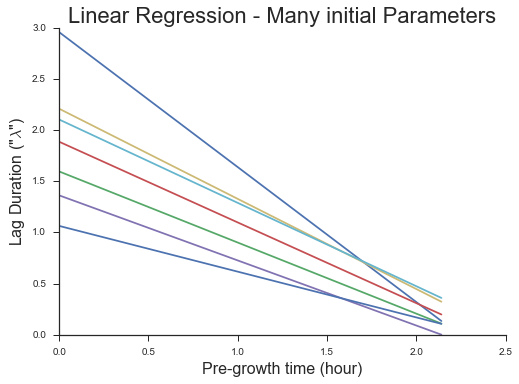

In [15]:
''' linear regression fitting '''

for i,experiment in enumerate(lags):
    slope, intercept, r_value, p_value, std_err = linregress(pgds, lags[i])
    lag_duration = (intercept + slope * pgds)
    print("for experiment", i , "- P-value:", p_value, ", R^2:", (r_value)**2, ", slope:", slope)
      
    plt.plot(pgds, lag_duration) # predictions
plt.title('Linear Regression - Many initial Parameters', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration ("$\lambda$")', size=16)

sns.despine()
#plt.savefig('many_initial_params.png')